In [1]:
import geopandas as gpd
import pandas as pd
from pyspatialml import Raster
from copy import deepcopy
import os
import tempfile
import rasterio.plot
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# set working directory
os.chdir("/Users/giandomenico/Documents/SAPIENZA/AR/ABDAC/def_regionale")

xy_path = "dati/xy_clean.gpkg"
xy = gpd.read_file(xy_path).drop(columns='geometry_idx')

In [3]:
#%% Pipeline for model training

# Define categorical and numerical features
categorical_features = ['wlc', 'lithology']  # List of categorical feature names
categorical_features = [5, 9]  # List of categorical feature names

numerical_features = [col for col in xy.columns if col not in ['label', 'geometry', 'lithology', 'wlc']] # List of numerical feature names
numerical_features = [0,1,2,3,4,6,7,8,10,11,12,13] # List of numerical feature names

# Define columns to reclassify
columns_to_reclassify = ['slope_deg', 'rel_relief', 'twi', 'curv_max']
columns_to_reclassify = [0, 2, 1, 8]

# Define preprocessing steps for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', RobustScaler()),    # Scaling
    # ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)),  # Discretize the features
    # ('quantile_transformer', QuantileTransformer(n_quantiles=4, output_distribution='uniform', random_state=0))  # Quantile-based transformation
    ])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
    ])


# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
        ])

classifier = GradientBoostingClassifier(random_state=42, n_estimators=150, 
                                        max_depth=12, min_samples_split=10,
                                        max_features=.75, learning_rate=0.1)

# Create the pipeline by combining the preprocessor with the classifier
# Pipeline definition
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
    ])


In [4]:
# Create Subsets
# Split the dataset into features and target
X = xy.drop(['label', 'geometry'], axis=1)#.values
y = xy['label']#.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Fit the preprocessing pipeline to the training data
pipeline.fit(X_train.values, y_train.values)
X_test_transformed = pipeline['preprocessor'].transform(X_test.values)

In [5]:
# Parameter grid for GridSearchCV
param_grid = {
    # 'classifier__n_estimators': [50, 100, 150, 200, 250],                    # Number of boosting stages to perform
    # 'classifier__max_depth': [None, 4, 6, 8, 10, 13],                        # Maximum depth of the individual trees
    # 'classifier__min_samples_split': [2, 5, 10, 15, 20],                     # Minimum number of samples required to split an internal node
    # 'classifier__min_sample_leaf': {2, 4, 6, 8, 10},                         # Minimum number of samples required to be at a leaf node
    # 'classifier__max_features': ['sqrt', 'auto', 0.5, 0.75]
    # 'classifier__learning_rate'=0.1,                                          # Shrinks the contribution of each tree
    # 'classifier__max_leaf_nodes=None,                                         # Maximum number of leaf nodes per tree

    'classifier__n_estimators': [150],
    'classifier__max_depth': [10, 12, 14],
    'classifier__min_samples_split': [10],
    'classifier__max_features': [0.75],
    'classifier__learning_rate': [0.1],
}

# Setup GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train.values, y_train.values)


# Best model evaluation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test.values)


report_best = classification_report(y_test, y_pred_best)

print("Best Model Performance on Test Set:\n", report_best)
print("Best Parameters:\n", grid_search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Model Performance on Test Set:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      2725
           1       0.79      0.74      0.77      1727

    accuracy                           0.82      4452
   macro avg       0.82      0.81      0.81      4452
weighted avg       0.82      0.82      0.82      4452

Best Parameters:
 {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__max_features': 0.75, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}


In [9]:
#%% Model Testing
scores = cross_validate(
    estimator=pipeline,
    X=X.values,
    y=y.values,
    # groups=df_polygons.index.droplevel("pixel_idx"),
    scoring=('precision', 'recall', 'f1'),
    cv=5,
    n_jobs=-1,
    return_train_score=True
    )


print(scores['test_f1'].mean())

0.678609566391292


In [12]:
#%% MODEL PRUNING
from sklearn.metrics import f1_score

# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
max_depth_values = [i for i in range(2, 18, 2)]

# evaluate the model for each depth
for i in max_depth_values:
        # configure the model
        pipeline['classifier'].max_depth=i
        # fit model on the training dataset
        pipeline.fit(X_train, y_train)
        # evaluate on the train dataset
        train_yhat = pipeline.predict(X_train)
        train_acc = f1_score(y_train, train_yhat)
        train_scores.append(train_acc)
        # evaluate on the test dataset
        test_yhat = pipeline.predict(X_test)
        test_acc = f1_score(y_test, test_yhat)
        test_scores.append(test_acc)
        # summarize progress
        print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>2, train: 0.748, test: 0.740
>4, train: 0.792, test: 0.755
>6, train: 0.857, test: 0.765
>8, train: 0.940, test: 0.762
>10, train: 0.991, test: 0.765
>12, train: 1.000, test: 0.759
>14, train: 1.000, test: 0.768
>16, train: 1.000, test: 0.767


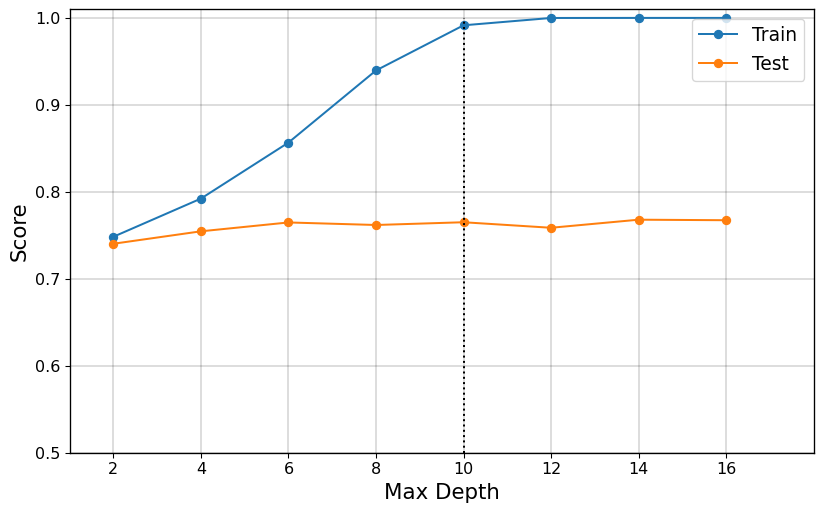

In [14]:
# Plot of train and test scores vs tree depth
fig, ax = plt.subplots(1,1,num=None, figsize=(10, 6), dpi=96, facecolor='w', edgecolor='black')
ax.plot(max_depth_values, train_scores, '-o', label='Train')
ax.plot(max_depth_values, test_scores, '-o', label='Test')
ax.vlines(x=10, ymin=0.5, ymax=1, linewidth=1.5, color='k', linestyle='dotted')

ax.grid(visible=True, which='major',axis="both", color='k', linestyle='-', linewidth=0.2)

plt.xticks(np.arange(2,18,2), fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Max Depth', fontsize=16)
plt.ylabel('Score', fontsize=16)

# spines
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)

# axis limits
plt.ylim([0.50, 1.01])
plt.xlim([1, 18])

# legend
plt.legend(frameon=True, fontsize=14)

plt.show()

/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/sklearn/base.py:486

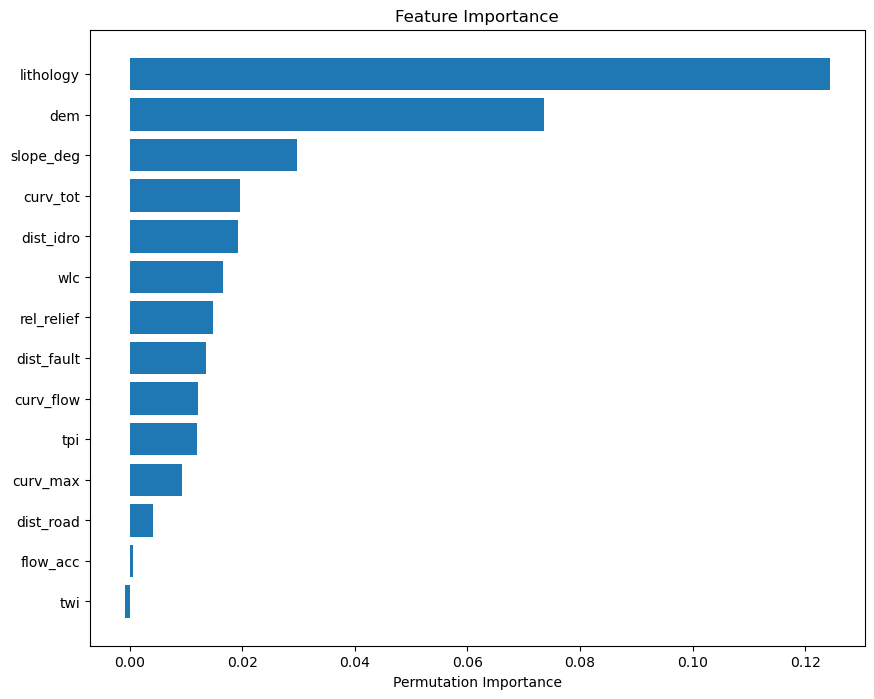

In [15]:
#%% FEATURE IMP
from sklearn.inspection import permutation_importance

# Compute the feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Sort the features by importance
sorted_idx = perm_importance.importances_mean.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

In [16]:
#%% save model
from joblib import load
from joblib import dump


# Specify the path to save the model file
model_path = 'codici/model/gb_29042024.joblib'

# Save the model
dump(best_model, model_path)

print(f"Model saved successfully at {model_path}")

In [17]:
# Load the model from the file
loaded_model = load(model_path)

print(loaded_model.score(X_test.values, y_test.values))

0.828167115902965
